In [13]:
import time
import pygame
import tensorflow as tf
from env import Snek
from agent import Agent
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np

#dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
print(tf.__version__)

2.2.0


In [14]:
mse = []
rewards = []
RED = (255, 0, 0)
BLUE = (0, 255, 255)
def plot(i, tot_reward, tot_loss, secs, epsilon):
    '''
    Function to plot mse and reward by epiode basis

    Input:
    i - Current episode number
    tot_reward - Total reward for current episode
    tot_loss - Total loss for current episode

    '''
    clear_output(wait = True)
    fig, ax = plt.subplots(1, 2, figsize = (12, 5))
    fig.suptitle("Episode : {} Reward: {} Loss: {} Epsilon: {} Time: {}".format(i, tot_reward, round(tot_loss, 3), round(epsilon, 3), round(secs, 3)))
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Rewards')
    ax[1].set_xlabel('Episodes')
    ax[1].set_ylabel('MSE')
    
    ax[1].plot(mse)
    ax[0].plot(rewards, label = 'Reward')
    ax[0].legend()
    ax[0].grid()
    ax[1].grid()
    plt.show()

def learn(noe, batch_size, env):
    '''
    Function which trains the agent

    Input:
    noe - No of episodes to train
    batch_size - Experience replay batch train size
    '''
    agent = Agent(env = env,  batch_size = batch_size, epsilon_decay = 0.999, net_input = (50, 50, 2))
    agent.prepopulate_er()
    print('Populated Er')
    env.food_num = 4
    pygame.init()

    for i in range(noe):
        tik = time.time()
        tot_reward = 0
        tot_loss = 0
        length = 0
        env.len = 0
        dis = pygame.display.set_mode((env.obs_size *10, env.obs_size *10))
        pygame.display.set_caption("AI Learns to play Snake")
        icon = pygame.image.load('/home/veeraraghavan/Desktop/DQL-Snake/Images/snake.png')
        pygame.display.set_icon(icon)
        gameover = False
        state = env.reset()
        stack = np.stack([state, state], axis = -1)
        while gameover != True:
            j = 0
            action = agent.epsilon_policy(stack)
            avg_reward = 0
            length += 1
            states = []
            states.append(state)
            for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        gameover = True
            while j < 2:

                dis.fill((0, 0, 0))
                if j == 1:
                    action = agent.epsilon_policy(np.stack(states, axis = -1))

                next_state, reward, done = env.step(action)
                avg_reward += reward
                j+=1
                if done:
                    state = env.reset()
                    states.append(next_state)
                    gameover = True
                    break
                else:
                    state = next_state
                    states.append(state)
                
                if agent.epsilon < 0.25:
                    time.sleep(0.01)
                
                for square in env.snake:
                    pygame.draw.rect(dis, BLUE, [square[1] * 10, square[0] * 10, 10, 10])
                for square in env.food:
                    pygame.draw.rect(dis, RED, [square[1] * 10, square[0] * 10, 10, 10])
                pygame.display.update()
            
            while(len(states)!= 3):
                states.append(states[-1])

            cstack = np.stack(states[:-1], axis = -1)
            next_stack = np.stack(states[1:], axis = -1)
            agent.add_exp(cstack, action, avg_reward, next_stack, done)
            tot_reward += avg_reward
            if not done:
                stack = next_stack
            else:
                gameover = True
            
            if length >750:
                gameover = True

            
        tok = time.time()
        tot_loss = agent.update_network()
        tot_loss/=length
        mse.append(tot_loss)
        rewards.append(tot_reward)
        plot(i, tot_reward, tot_loss, tok-tik, agent.epsilon)
        if i%1000 == 0 and i!=0:
            agent.dqn.save(str(i)+'model.h5')

In [15]:
env = Snek(size =50, rewards = {'died':-10, 'food':+100, 'live':+0.001}, food_val = +10, snake_val = -3, food_num = 4, food_decay = 0.999)

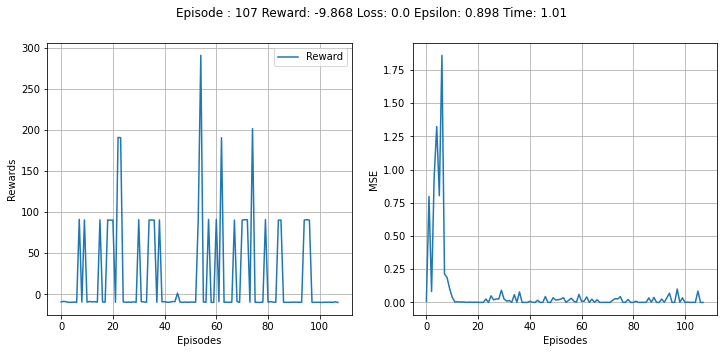

KeyboardInterrupt: 

In [16]:
learn(10000, 512, env)


In [12]:
pygame.quit()